# Dana-Farber Data Scientist Coding Assessment

### Overall Question: *Can you discover any mutations that are associated with treatment response?*

For this set of data, the goal was to find a set of genes which were more prevalent in patients who were either responders or non-responders to an experimental treatment based on the supplied mutation annotation format (.maf) file. Both the .maf file and patient sample-info.tsv files were loaded in and merged together based on common columns.

In [1]:
# Packages
import os
import sys
import math
import re
import itertools
import scipy as sp
from scipy.stats import fisher_exact, ttest_ind
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import seaborn as sns

# Check working directory
print('Current working dir:', os.getcwd())

Current working dir: /Users/jakeharris/Documents/GitHub/df-assignment


In [2]:
# Load in sample-info.tsv file
sample_info_path = os.path.join('vanallen-assessment', 'sample-information.tsv')
sample_info_df = pd.read_csv(sample_info_path, sep='\t')
print(sample_info_df.columns)
print('Number of patient entries:', len(sample_info_df))
sample_info_df.head()

Index(['Patient_ID', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode',
       'Response', 'Silent_mutations_per_Mb', 'Nonsynonymous_mutations_per_Mb',
       'Mutations_per_Mb'],
      dtype='object')
Number of patient entries: 50


,Patient_ID,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Response,Silent_mutations_per_Mb,Nonsynonymous_mutations_per_Mb,Mutations_per_Mb
0,Patient-0,Patient-0-Tumor,Patient-0-Normal,Non-Responder,2.87,6.77,9.64
1,Patient-1,Patient-1-Tumor,Patient-1-Normal,Responder,1.92,6.14,8.06
2,Patient-2,Patient-2-Tumor,Patient-2-Normal,Responder,1.32,2.84,4.16
3,Patient-3,Patient-3-Tumor,Patient-3-Normal,Non-Responder,1.78,5.00,6.78
4,Patient-4,Patient-4-Tumor,Patient-4-Normal,Responder,4.93,10.50,15.43


In [3]:
# Load in all patient .maf data as single dataframe
maf_dir = os.listdir(os.path.join('vanallen-assessment', 'mafs'))  # patient .maf data folder
mutations_df = pd.DataFrame()  # blank DF for later concatenation
for item in maf_dir:
    patient_df = pd.read_csv(os.path.join('vanallen-assessment', 'mafs', item), sep='\t')
    mutations_df = pd.concat([mutations_df, patient_df], ignore_index=True)
print(mutations_df.columns)
print('Number of mutation annotation rows for all patients:', len(mutations_df))
mutations_df.head()

Index(['Hugo_Symbol', 'Chromosome', 'Start_position', 'End_position',
       'Variant_Classification', 'Variant_Type', 'Reference_Allele',
       'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode',
       'Matched_Norm_Sample_Barcode', 'Protein_Change', 't_alt_count',
       't_ref_count'],
      dtype='object')
Number of mutation annotation rows for all patients: 15673


,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
0,CEP350,1,180063656,180063656,Missense_Mutation,SNP,G,G,A,Patient-36-Tumor,Patient-36-Normal,p.E2806K,12,28
1,CCDC88C,14,91739009,91739009,Missense_Mutation,SNP,C,C,T,Patient-36-Tumor,Patient-36-Normal,p.G2016E,36,57
2,KDM6B,17,7749509,7749509,Missense_Mutation,SNP,A,A,T,Patient-36-Tumor,Patient-36-Normal,p.Y117F,4,25
3,PGAP1,2,197781268,197781268,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.F117L,11,25
4,PARD6B,20,49366765,49366765,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.E287Q,21,88


### Subset for mutations that are nonsynonymous.
Any samples that had Variant Classification values of "Silent" were removed from the merged dataframe to create a dataframe consisting of only samples with nonsynymous mutations.

In [4]:
# Merge mutations_df and sample_info_df on common columns
merged_df = mutations_df.merge(sample_info_df, how='left', on=['Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode'])
print('Number of entries in merged_df:', len(merged_df))

# Filter out silent mutations from variant_classification column
print('Mutation variant types:', merged_df['Variant_Classification'].unique())
nonsynon_df = merged_df[merged_df['Variant_Classification'] != 'Silent']  # only nonsynonymous mutations df
print('Number of nonsynonymous mutations:', len(nonsynon_df))
nonsynon_df.head()

Number of entries in merged_df: 15673
Mutation variant types: ['Missense_Mutation' 'Silent' 'Nonsense_Mutation' 'Splice_Site']
Number of nonsynonymous mutations: 11247


,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count,Patient_ID,Response,Silent_mutations_per_Mb,Nonsynonymous_mutations_per_Mb,Mutations_per_Mb
0,CEP350,1,180063656,180063656,Missense_Mutation,SNP,G,G,A,Patient-36-Tumor,Patient-36-Normal,p.E2806K,12,28,Patient-36,Responder,2.47,6.0,8.47
1,CCDC88C,14,91739009,91739009,Missense_Mutation,SNP,C,C,T,Patient-36-Tumor,Patient-36-Normal,p.G2016E,36,57,Patient-36,Responder,2.47,6.0,8.47
2,KDM6B,17,7749509,7749509,Missense_Mutation,SNP,A,A,T,Patient-36-Tumor,Patient-36-Normal,p.Y117F,4,25,Patient-36,Responder,2.47,6.0,8.47
3,PGAP1,2,197781268,197781268,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.F117L,11,25,Patient-36,Responder,2.47,6.0,8.47
4,PARD6B,20,49366765,49366765,Missense_Mutation,SNP,G,G,C,Patient-36-Tumor,Patient-36-Normal,p.E287Q,21,88,Patient-36,Responder,2.47,6.0,8.47


### Find the 15 most common mutantions.
I found that this question could possibly be up for different interpretations. For the first count, I counted the number of times each mutation sample occurred within the dataframe, even though patients could have multiple protein changes involving the same gene.

In [5]:
# Find the 15 most common mutant (MT) genes (regardless of multiple MT gene occurrence in same patient)
top15_MTgenes = nonsynon_df[['Hugo_Symbol']].value_counts(dropna=False).to_frame('MT_Count').reset_index()
top15_MTgenes.head(15)

,Hugo_Symbol,MT_Count
0,TTN,41
1,TP53,30
2,ERBB4,27
3,SPEN,22
4,MUC16,22
5,KMT2C,20
6,KMT2D,17
7,ERBB3,16
8,FRG1B,14
9,ZNF91,13


For the next version, I only counted for *unique* appearances of each mutant gene to eliminate multiple sample counts from the same patient. Results were similar to the original count.

In [6]:
# Find 15 most common MT genes (unique MT genes only)
top15_unique_genes = nonsynon_df.groupby(['Hugo_Symbol'])['Patient_ID'].nunique()
top15_unique_genes = top15_unique_genes.to_frame('Unique_Count').sort_values(by=['Unique_Count'], ascending=False).reset_index()
top15_unique_genes.head(15)

,Hugo_Symbol,Unique_Count
0,TTN,27
1,TP53,25
2,MUC16,20
3,ERBB4,18
4,KMT2D,13
5,ERBB3,11
6,FRG1B,10
7,RB1,10
8,ZNF208,9
9,FAT4,9


Finally, I counted unique gene-protein_change mutations to find which specific SNPs showed up the most frequently. This involved having to account for the fact that some variants classified as "splice sites" had NaN values for protein_change. I chose to not drop these values when counting occurrences.

In [7]:
# Find the 15 most common specific mutations
### NOTE: accounting for NaN values unique to splice_site variants yields different results
for variant in nonsynon_df['Variant_Classification'].unique():
    nan_check = nonsynon_df[nonsynon_df['Variant_Classification']==variant].isnull().values.any()
    print(variant, nan_check)  # check for NaN values in variant_classifications
print('Number of splice_site mutations:', len(nonsynon_df[nonsynon_df['Variant_Classification']=='Splice_Site']))  # 392 splice_site MT variants
print('Number of splice_site NaN variants:', nonsynon_df['Protein_Change'].isnull().sum())  # 209 splice_site NaNs variant values

# Not accounting for splice_site variant classification (drop NaN protein_change values)
# top15_noNan = nonsynon_df[['Hugo_Symbol', 'Variant_Classification', 'Protein_Change']].value_counts().to_frame('Count').reset_index()
# print('Without NaN Variant_Classification values: \n', top15_noNan.head(15))

# Top 15 specific protein changes -- accounting for splice_site variant_classification (don't drop NaN protein_change values)
top15_wSplice = nonsynon_df[['Hugo_Symbol', 'Variant_Classification', 'Protein_Change']].value_counts(dropna=False).to_frame('Count').reset_index()
top15_wSplice.head(15)

Missense_Mutation False
Nonsense_Mutation False
Splice_Site True
Number of splice_site mutations: 392
Number of splice_site NaN variants: 209


,Hugo_Symbol,Variant_Classification,Protein_Change,Count
0,ERBB4,Missense_Mutation,p.S1289A,14
1,ERBB3,Missense_Mutation,p.H228Q,5
2,ERBB4,Missense_Mutation,p.Q707E,5
3,PIK3CA,Missense_Mutation,p.E545K,5
4,TYRO3,Missense_Mutation,p.L819M,4
5,ERBB3,Missense_Mutation,p.M91I,4
6,ERBB4,Missense_Mutation,p.E317K,4
7,RXRA,Missense_Mutation,p.S330F,4
8,MAP2K1,Missense_Mutation,p.F53L,4
9,FAM47C,Missense_Mutation,p.Q225E,4


### Comparison of mutational burden and treatment response
As a way to examine a possible relationship between the mutational burden, defined as the set of values in the nonsynonymous_mutations_per_Mb column, and response status, I performed a t-test comparing the mean mutational burden values between responder and non-responder patients. This resulted in a significant difference between the two groups as responders had a lower mean mutation murden than non-responders (p-value=0.0001). 

Along with this, I also looked at the relationship at the number of mutant (MT) and wild-type (WT) genes per patient in each response group. Because not every patient contained a sample record for the nearly 7000 unique genes listed in the original .maf file, I went on the assumption that if a patient lacked a sample record for a given gene, then he or she was wild-type for that given gene. Separate t-tests showed a higher mean number of MT gene samples in responders than non-responders (p-value=0.0002) while non-responders had a higher mean number of WT samples than responders (p=0.0002).

Mean nonsynonymous mutation Mb count in responders: 8.475999999999999
Mean nonsynonymous mutation Mb count in non-responders: 3.6564000000000005
T-test p-value for mutations per Mb between (non-)responders: 0.0001472493333889371
Mean num. responders MT genes: 291.84
Mean num. non-responders MT genes: 132.2
T-test p-value MT: 0.00020081134967416667
Mean num. responders WT genes: 6635.16
Mean num. non-responders WT genes: 6794.8
T-test p-value WT: 0.00020081134967416157


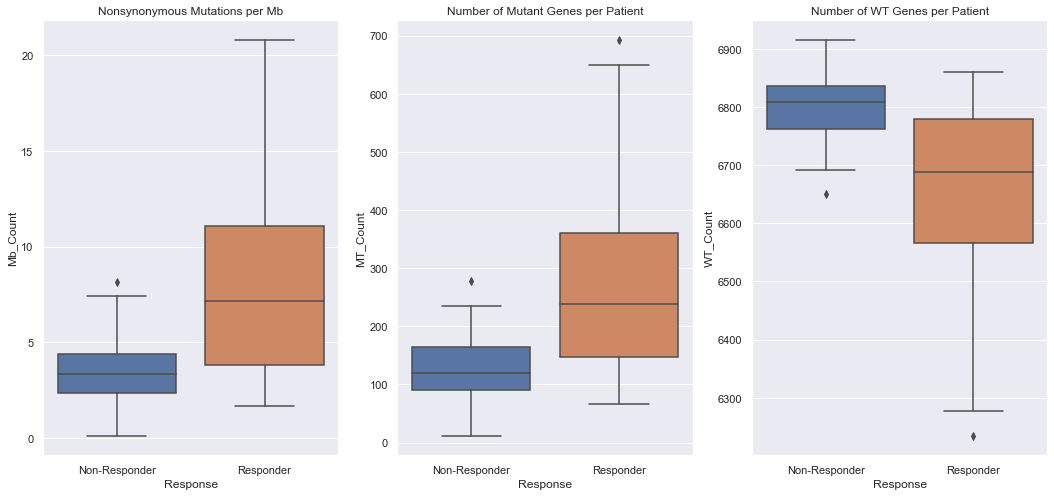

In [8]:
# Run t-test to look at comparison between response and mutational burden (total num. of mutations/mutations per Mb)
def responses_ttests():
    
    # setup DF of nonsynonymous mutations per Mb per patient
    Mb_count_df = nonsynon_df.groupby(['Patient_ID', 'Response'])['Nonsynonymous_mutations_per_Mb'].unique()
    Mb_count_df = Mb_count_df.to_frame('Mb_Count').reset_index()
    Mb_count_df['Mb_Count'] = Mb_count_df['Mb_Count'].apply(lambda row: row[0]) # convert lists to floats
    
    # record counts of mutations_per_Mb per response group
    Mb_count_resp = [i for i in Mb_count_df[Mb_count_df['Response']=='Responder']['Mb_Count']] # responders
    print('Mean nonsynonymous mutation Mb count in responders:', np.array(Mb_count_resp).mean())
    Mb_count_non = [i for i in Mb_count_df[Mb_count_df['Response']=='Non-Responder']['Mb_Count']] # non-responders
    print('Mean nonsynonymous mutation Mb count in non-responders:', np.array(Mb_count_non).mean())
    
    # T-test to compare mean mutations_per_Mb per response group
    tstat_mb, pval_mb = ttest_ind(Mb_count_resp, Mb_count_non)
    print('T-test p-value for mutations per Mb between (non-)responders:', pval_mb)
    
    # setup DF of count of mutant genes per patient
    mt_count_df = nonsynon_df.groupby(['Patient_ID', 'Response'])['Hugo_Symbol'].nunique()
    mt_count_df = mt_count_df.to_frame('MT_Count').reset_index()
    
    # record counts of mutant genes per group
    n_mt_genes_resp = [i for i in mt_count_df[mt_count_df['Response']=='Responder']['MT_Count']] # MT responders
    print('Mean num. responders MT genes:', np.array(n_mt_genes_resp).mean())
    n_mt_genes_non = [i for i in mt_count_df[mt_count_df['Response']=='Non-Responder']['MT_Count']] # MT non-responders
    print('Mean num. non-responders MT genes:', np.array(n_mt_genes_non).mean())
    
    # T-test to compare mean num. of mt genes between (non-)responders
    tstat_mt, pval_mt = ttest_ind(n_mt_genes_resp, n_mt_genes_non)
    print('T-test p-value MT:', pval_mt)
    
    # record count of wild-type genes per group
    n_genes = len(nonsynon_df['Hugo_Symbol'].unique())
    mt_count_df['WT_Count'] = mt_count_df.apply(lambda row: n_genes - row['MT_Count'], axis=1)
    n_wt_genes_resp = [i for i in mt_count_df[mt_count_df['Response']=='Responder']['WT_Count']] # WT responders
    print('Mean num. responders WT genes:', np.array(n_wt_genes_resp).mean())
    n_wt_genes_non = [i for i in mt_count_df[mt_count_df['Response']=='Non-Responder']['WT_Count']] # WT non-responders
    print('Mean num. non-responders WT genes:', np.array(n_wt_genes_non).mean())
    
    # T-test to compare mean num. of wt genes between (non-)responders
    tstat_wt, pval_wt = ttest_ind(n_wt_genes_resp, n_wt_genes_non)
    print('T-test p-value WT:', pval_wt)
    
    # plots of results
    sns.set(rc={'figure.figsize': (18,8)})
    fig, ax = plt.subplots(1,3)
    sns.boxplot(data=Mb_count_df, x='Response', y='Mb_Count', ax=ax[0]).set(title='Nonsynonymous Mutations per Mb')
    sns.boxplot(data=mt_count_df, x='Response', y='MT_Count', ax=ax[1]).set(title='Number of Mutant Genes per Patient')
    sns.boxplot(data=mt_count_df, x='Response', y='WT_Count', ax=ax[2]).set(title='Number of WT Genes per Patient')
    # return plot
    # return np.array(n_mt_genes_resp), np.array(n_mt_genes_non), pval
    
responses_ttests()

### Perform a statistical test to explore if any mutated genes are enriched in patients who either responded or not.
In order to answer the overall question, we must first consider the type of data we are working with and how it can be utilized. I feel that there are two  patient categorical data we are comparing: gene sample type (mutation vs. wild-type) and response (responder vs. non-responder). Based on my previous assumptions of a gene being wild-type for a given patient if he or she does not have a sample record for it, it appears that we can count the number of patients who fit into each response-gene type pairing.

This then leads me to believe that a Fisher's Exact Test may be a good fit for this data as our sample size is relatively small. We can create 2x2 contingency tables and then use SciPy to count and calculate the probabilities that the ratio of MT-responders is significantly different to the ratio of WT-responders for each gene. 

In [9]:
# Check for MT genes which are enriched in responders vs. nonresponders
# 1. check to see if gene listing is only present in patients with nonsynonymous mutation
    ## (num. patients w/ mutation) + (num. patients w/ WT) = 50
# 2. 4 categories:
    ## WT and responder
    ## mutant and responder
    ## WT and nonresponder
    ## mutant and nonresponder
# 3. Run Fisher's exact test on 2x2 contingency table of all genes
    ## one-sided test to test for alt. hypothesis that  
    ## WT: wild-type, MT: mutant, R: responder, NR: non-responder
    ##      MT   WT
    ## R    x
    ## NR

# Function to check for enrichment of MT gene in responders vs. non-responders -- Fisher's exact test
def gene_enrichment_fishers(gene):
    
    # (Non-)responder MT gene counts
    full_mt_df = nonsynon_df.groupby(['Hugo_Symbol', 'Response', 'Patient_ID'])['Patient_ID'].nunique() # all MT genes
    full_mt_df = full_mt_df.to_frame('Count').reset_index()
    mt_gene_df = full_mt_df[full_mt_df['Hugo_Symbol']==gene] # specific MT gene
    mt_resp = mt_gene_df[mt_gene_df['Response']=='Responder'].value_counts().sum() # MT responders
    mt_non = mt_gene_df[mt_gene_df['Response']=='Non-Responder'].value_counts().sum() # MT non-responders
    
    # (Non-)responder wild-type gene counts (assumes gene isn't listed for 25 (non-)responder patients in provided nonsynonymous_DF)
    wt_resp = 25 - mt_resp # WT responders
    wt_non = 25 - mt_non # WT non-responders
    
    # relative frequencies
    mt_resp_freq = mt_resp/(mt_resp+mt_non)
    mt_non_freq = mt_non/(mt_resp+mt_non)
    wt_resp_freq = wt_resp/(wt_resp+wt_non)
    wt_non_freq = wt_non/(wt_resp+wt_non)
    total_mt = mt_resp + mt_non
    total_wt = wt_resp + wt_non
    total_resp = mt_resp + wt_resp
    total_non = mt_non + wt_non
    mt_wt_ratio = total_mt/total_wt

    # run Fisher's exact test on gene/response 2x2 contingency table
    cont_table = np.array([[mt_resp, wt_resp], [mt_non, wt_non]])
    oddsratio, pvalue = fisher_exact(cont_table)
    gene_results = {'Gene': gene, 'P-value': float(pvalue), '-Log10(P-value)': -math.log10(pvalue), 'Odds_Ratio': oddsratio, \
        'MT_Resp': mt_resp, 'WT_Resp': wt_resp, 'MT_Non-Resp': mt_non, 'WT_Non-Resp': wt_non, \
        'Total_MT': total_mt, 'Total_WT': total_wt, 'MT_Resp_Freq': mt_resp_freq, 'WT_Resp_Freq': wt_resp_freq, \
        'MT_Non_Freq': mt_non_freq, 'WT_Non_Freq': wt_non_freq, 'MT/WT_Ratio': mt_wt_ratio}
    
    return gene_results

The given results from Fisher's test showed significant differences (p<0.05) in ratios for the genes ERCC2, HERC1, MROH2B, HECTD1, AKAP9, MACF1, and KMT2C, indicating possible enrichment in responders.

In [10]:
# Run Fisher's exact test on all genes
genes = nonsynon_df['Hugo_Symbol'].unique()
full_results = []
for gene in tqdm(genes):
    full_results.append(gene_enrichment_fishers(gene)) 

# Save Fisher's data as DF, filter for signifigant values
fishers_df = pd.DataFrame.from_dict(full_results).sort_values(by=['P-value'], ascending=True, ignore_index=True)
fishers_df['Sig_Enrichment'] = fishers_df.apply(lambda row: True if row['P-value'] <= 0.05 else False, axis=1)
fishers_sig_df = fishers_df[fishers_df['P-value']<=0.1] # p<=0.1 for display purposes
fishers_sig_df.head(10)

100%|██████████| 6927/6927 [01:21<00:00, 84.71it/s]


,Gene,P-value,-Log10(P-value),Odds_Ratio,MT_Resp,WT_Resp,MT_Non-Resp,WT_Non-Resp,Total_MT,Total_WT,MT_Resp_Freq,WT_Resp_Freq,MT_Non_Freq,WT_Non_Freq,MT/WT_Ratio,Sig_Enrichment
0,ERCC2,0.001631,2.787590,inf,9,16,0,25,9,41,1.000,0.390244,0.000,0.609756,0.219512,True
1,HERC1,0.022290,1.651894,inf,6,19,0,25,6,44,1.000,0.431818,0.000,0.568182,0.136364,True
2,MROH2B,0.022290,1.651894,inf,6,19,0,25,6,44,1.000,0.431818,0.000,0.568182,0.136364,True
3,HECTD1,0.022290,1.651894,inf,6,19,0,25,6,44,1.000,0.431818,0.000,0.568182,0.136364,True
4,AKAP9,0.022290,1.651894,inf,6,19,0,25,6,44,1.000,0.431818,0.000,0.568182,0.136364,True
5,MACF1,0.022290,1.651894,inf,6,19,0,25,6,44,1.000,0.431818,0.000,0.568182,0.136364,True
6,KMT2C,0.048797,1.311606,9.333333,7,18,1,24,8,42,0.875,0.428571,0.125,0.571429,0.190476,True
7,ANK2,0.050152,1.299712,inf,5,20,0,25,5,45,1.000,0.444444,0.000,0.555556,0.111111,False
8,CHD5,0.050152,1.299712,inf,5,20,0,25,5,45,1.000,0.444444,0.000,0.555556,0.111111,False
9,COL6A6,0.050152,1.299712,inf,5,20,0,25,5,45,1.000,0.444444,0.000,0.555556,0.111111,False


### Create a scatterplot of the results from your test.
For this question, the acquired p-values were originally plotted against the number of patients who had mutations for each unique gene using Seaborn. However, this method was overall lackluster. In order to make a more interesting plot with interactive elements, the original results dataframe was melted down to create tidy rows with unique values which could be incorporated into the creation of the plot. This dataframe was then used as the basis for a separate scatterplot made using Plotly with a y-axis of -Log10(P-value), color markers to distinguish response type, and a horizontal line along -Log10(0.05) to give a visual marker of significance. 

[Text(0.5, 1.0, "Fisher's Exact Test")]

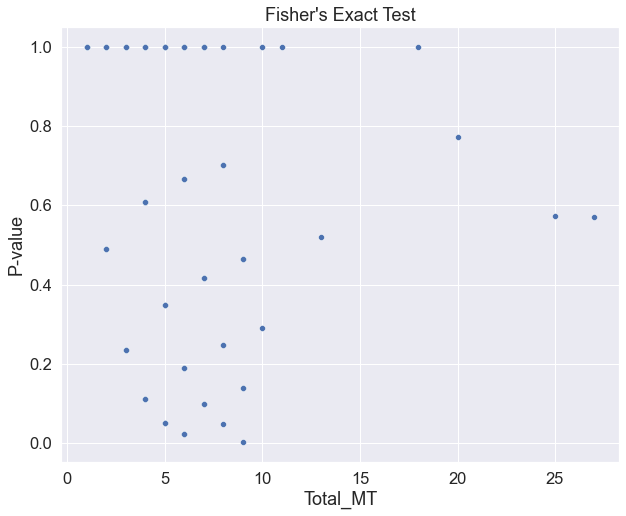

In [11]:
# Original scatterplot of number of MT patients vs. Fisher's p-values
sns.set(rc={'figure.figsize': (10,8)}, font_scale=1.5)
sns.scatterplot(data=fishers_df, x='Total_MT', y='P-value').set(title="Fisher's Exact Test")

In [13]:
# Select for significant genes from Fisher's test, melt table for better use
melt_df = nonsynon_df.groupby(['Hugo_Symbol', 'Response'])['Patient_ID'].nunique()
melt_df = melt_df.to_frame('MT').sort_values(by=['MT'], ascending=False).reset_index()
melt_df['WT'] = melt_df.apply(lambda row: 25 - row['MT'], axis=1)
melt_df = melt_df.melt(['Hugo_Symbol', 'Response'], var_name='Gene_Type', value_name='Count')

# check each sig. gene for response entries -- if no entries, then assume all 25 (non-)responders are WT
for gene in tqdm(nonsynon_df['Hugo_Symbol'].unique()):
    if len(melt_df[(melt_df['Response']=='Responder') & (melt_df['Hugo_Symbol']==gene)].value_counts()) != 2:
        rows = pd.DataFrame([(gene, 'Responder', 'MT', 0), (gene, 'Responder', 'WT', 25)], columns=melt_df.columns)
        melt_df = pd.concat([melt_df, rows], ignore_index=True)
    elif len(melt_df[(melt_df['Response']=='Non-Responder') & (melt_df['Hugo_Symbol']==gene)].value_counts()) != 2:
        rows = pd.DataFrame([(gene, 'Non-Responder', 'MT', 0), (gene, 'Non-Responder', 'WT', 25)], columns=melt_df.columns)
        melt_df = pd.concat([melt_df, rows], ignore_index=True)
    else:
        pass
melt_df['Rel_Resp_Freq'] = melt_df.apply(lambda row: row['Count']/25, axis=1) # relative response frequency

# transfer P-values from original fisher_df
pval_dict = fishers_df.set_index('Gene')['P-value'].to_dict()
log10_dict = fishers_df.set_index('Gene')['-Log10(P-value)'].to_dict()
melt_df['P-value'] = [pval_dict[gene] for gene in melt_df['Hugo_Symbol']]
melt_df['-Log10(Pval)'] = [log10_dict[gene] for gene in melt_df['Hugo_Symbol']]
melt_df['Sig_Enrichment'] = melt_df.apply(lambda row: True if row['P-value']<=0.05 else False, axis=1)
melt_df = melt_df.reset_index(drop=True)
melt_df.head()

100%|██████████| 6927/6927 [00:40<00:00, 170.35it/s]


,Hugo_Symbol,Response,Gene_Type,Count,Rel_Resp_Freq,P-value,-Log10(Pval),Sig_Enrichment
0,TTN,Non-Responder,MT,15,0.60,0.570916,0.243428,False
1,TP53,Non-Responder,MT,14,0.56,0.572138,0.242499,False
2,TTN,Responder,MT,12,0.48,0.570916,0.243428,False
3,TP53,Responder,MT,11,0.44,0.572138,0.242499,False
4,MUC16,Non-Responder,MT,11,0.44,0.773287,0.111659,False


In [14]:
# Make scatterplot of association between MT patient count vs. Fisher's results using plotly
import plotly.express as px

melt_mt_df = melt_df[melt_df['Gene_Type']=='MT']
fig = px.scatter(melt_mt_df, x='Count', y='-Log10(Pval)', color='Response', hover_data=['Hugo_Symbol', 'P-value', 'Sig_Enrichment'], \
    labels={'Count':'MT Patient Count'}, title="Gene Enrichment in Mutant Patients (Fisher's Exact Test)")
fig.add_hline(y=-math.log10(0.05)) # pval=0.05 significance line
fig.show()

### Further visualizations
Considering scatterplots showing p-values from Fisher's Exact Test are considered unusual in many publications, many authors instead choose to visualize differences between categorical ratios by using mosaic plots. These act as visual representations of the 2x2 contingency tables used when calculating Fisher's p-values. 

In [15]:
# create mosaic table of significant gene_type/response counts to visualize contingency tables
from statsmodels.graphics.mosaicplot import mosaic
 
def gene_mosaic_plot(gene, print_table=None):
        
    # gene/response crosstable
    cr_table = pd.crosstab(melt_df[melt_df['Hugo_Symbol']==gene]['Response'], melt_df[melt_df['Hugo_Symbol']==gene]['Gene_Type'], \
        values=melt_df[melt_df['Hugo_Symbol']==gene]['Count'], aggfunc='sum') 
    if print_table==True:
        print(gene, '\n', cr_table)
    
    # plot visual properties
    props = {} 
    props[('MT','Responder')] = {'facecolor':'red', 'edgecolor':'white'}
    props[('WT','Responder')] = {'facecolor':'red', 'edgecolor':'white'}
    props[('MT','Non-Responder')] = {'facecolor':'xkcd:aqua','edgecolor':'white'}
    props[('WT','Non-Responder')] = {'facecolor':'xkcd:aqua','edgecolor':'white'}
    data = {('MT','Responder'): cr_table['MT']['Responder'], ('WT','Responder'): cr_table['WT']['Responder'], \
            ('MT','Non-Responder'): cr_table['MT']['Non-Responder'], ('WT','Non-Responder'): cr_table['WT']['Non-Responder']}
    labelizer = lambda x: data[x]
    
    # mosaic plot
    plt.rcParams['figure.figsize']=(4,4)
    mosaic(data, labelizer=labelizer, properties=props, title=gene)
    # return gene_fig

ERCC2 
 Gene_Type      MT  WT
Response             
Non-Responder   0  25
Responder       9  16
KMT2C 
 Gene_Type      MT  WT
Response             
Non-Responder   1  24
Responder       7  18


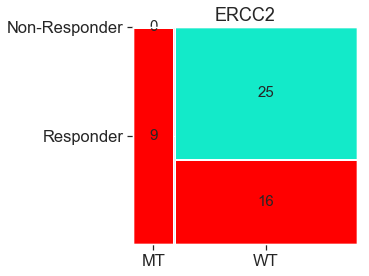

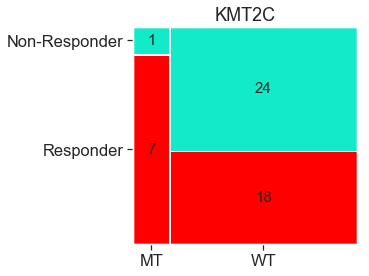

In [16]:
# Mosaic plots of crosstable of significant genes from Fisher's test
gene_mosaic_plot('ERCC2', True)
gene_mosaic_plot('KMT2C', True)

### Comparing number of WT vs. MT samples and number mutations per Mb
Looking at ERCC2, the most significantly affected gene between response and mutation type groups, there are 9 patients who fit into the MT-responder category with 25 patients falling into the WT-non-responder category and the remaining 16 categorized as WT-responders (see mosaic plot above). 

Similar to the earlier t-test comparing mutation burden and response, there appears to be a significant difference in the mean mutation burden based on the number of nonsynonymous mutations in Mb_count between MT patients and WT patients (p-value=0.0008). 

ERCC2 MT mean Mb counts: 10.674444444444445
ERCC2 WT mean Mb counts: 5.054634146341464
T-stat: 3.5715854218050165
P-value: 0.0008192149762925898


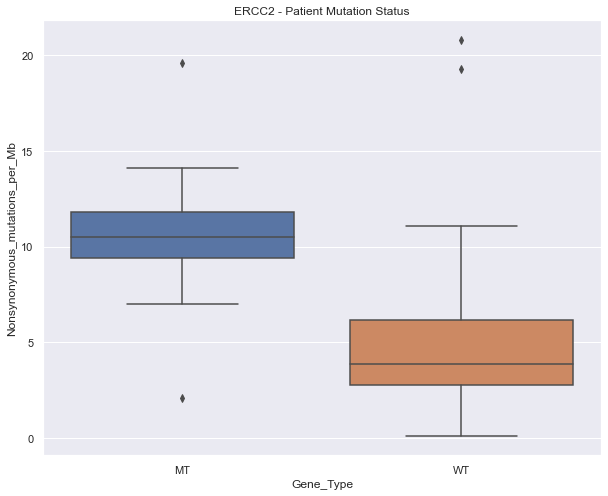

In [17]:
# compare nonsynonymous_mutations_per_Mb between MT/WT patients
def ercc2_mt_compare():
    
    # create DF of MT/WT patients with Mb counts
    ercc2_df = nonsynon_df[nonsynon_df['Hugo_Symbol']=='ERCC2']
    ercc2_df = ercc2_df.groupby(['Patient_ID', 'Nonsynonymous_mutations_per_Mb'])['Patient_ID'].nunique()
    ercc2_df = ercc2_df.to_frame('MT').reset_index()
    for patient in nonsynon_df['Patient_ID'].unique():
        if ercc2_df['Patient_ID'].isin([patient]).any():
            pass
        else:
            patient_ercc2 = {'Patient_ID': patient, \
                'Nonsynonymous_mutations_per_Mb': nonsynon_df[nonsynon_df['Patient_ID']==patient]['Nonsynonymous_mutations_per_Mb'].unique(), 'MT': 0}
            patient_df = pd.DataFrame.from_dict(patient_ercc2)
            ercc2_df = pd.concat([ercc2_df, patient_df], ignore_index=True)
    ercc2_df['Gene_Type'] = ercc2_df.apply(lambda row: 'MT' if row['MT']==1 else 'WT', axis=1)
    
    # Run t-test to compare mean Mb_counts between MT/WT groups
    mt_group = np.array([x for x,y in zip(ercc2_df['Nonsynonymous_mutations_per_Mb'], ercc2_df['MT']) if y==1]) # MT Mb_counts
    wt_group = np.array([x for x,y in zip(ercc2_df['Nonsynonymous_mutations_per_Mb'], ercc2_df['MT']) if y==0]) # WT Mb_counts
    tstat, pval = ttest_ind(mt_group, wt_group)
    print('ERCC2 MT mean Mb counts:', mt_group.mean())
    print('ERCC2 WT mean Mb counts:', wt_group.mean())
    print('T-stat:', tstat)
    print('P-value:', pval)
    
    # Boxplot to visualize results
    sns.set(rc={'figure.figsize': (10,8)})
    sns.boxplot(data=ercc2_df, x='Gene_Type', y='Nonsynonymous_mutations_per_Mb').set(title='ERCC2 - Patient Mutation Status')

ercc2_mt_compare()

### Conclusions and Remarks

This set of gene mutations features thousands of genes, only two of which (TTN, TP53) occur in at least half of the patient population. Responders to treatment appear to show a propensity to a higher number of mutations compared to non-responders. Based on a Fisher's Exact Test, seven gene samples appear to be enriched in mutant responders: ERCC2, HERC1, MROH2B, HECTD1, AKAP9, MACF1, and KMT2C. Comparing patients with wild-type vs. mutant version of the ERCC2 gene shows a significant difference between the groups with mutant patients having a higher mean mutation Mb count than wild-type patients.

One way to expand this analysis would be to gain expression values for the individual genes to perform a more quantitative analysis of the genetic difference between each response group. For example, this would allow for plotting the log2(fold change) between response groups in order to create a volcano plot for visualizing the difference in gene expression levels. This data could also allow for a more in-depth analysis between responders and mutation status by opening up the possibility to gene set expression analysis (GSEA). Along with individual gene difference data, this could allow for analysis into changes in genetic pathways between response groups due to mutation status. 